<a href="https://colab.research.google.com/github/dhirajkk91/Fashion-MNIST-Neural-Network-Scratch/blob/main/Fashion_MNIST_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
zalando_research_fashionmnist_path = kagglehub.dataset_download('zalando-research/fashionmnist')

print('Data source import complete.')

100%|██████████| 68.8M/68.8M [00:00<00:00, 128MB/s]

Extracting files...


Data source import complete.


In [3]:
import numpy as np   # for numerical operations, matrix multiplication, etc.
import pandas as pd  # for handling CSV datasets easily
import os # Import os for path manipulation

# -------------------------------
# Load and prepare the dataset
# -------------------------------
# Fashion MNIST CSV file: 60000 training images, each flattened to 784 pixels + 1 label column
data_train = pd.read_csv(os.path.join(zalando_research_fashionmnist_path, "fashion-mnist_train.csv"))

# Convert dataframe to numpy array for fast numerical operations
# Transpose to make the shape (features+label, samples)
data_train = np.array(data_train).T   # Shape: (785, 60000)

# The first row contains labels
Y = data_train[0]

# Remaining rows contain pixel values
# Normalize pixel values to [0, 1] for faster convergence
X = data_train[1:785] / 255.0

# -------------------------------
# One-hot encoding
# -------------------------------
# Converts labels to a one-hot matrix for multi-class classification
def one_hot(Y, num_classes=10):
    m = Y.size
    one_hot_Y = np.zeros((num_classes, m))
    one_hot_Y[Y, np.arange(m)] = 1
    return one_hot_Y

Y_oh = one_hot(Y)

# Example:
# If Y[0] = 3, then Y_oh[:,0] = [0,0,0,1,0,0,0,0,0,0]

# -------------------------------
# Initialize network parameters
# -------------------------------
def init_params():
    """
    Initializes weights and biases for 3-layer neural network.
    He initialization is used for ReLU activation:
        W ~ N(0, sqrt(2 / fan_in))
    """
    W1 = np.random.randn(512, 784) * np.sqrt(2. / 784)  # Layer 1 weights
    b1 = np.zeros((512, 1))                             # Layer 1 biases
    W2 = np.random.randn(256, 512) * np.sqrt(2. / 512)  # Layer 2 weights
    b2 = np.zeros((256, 1))                             # Layer 2 biases
    W3 = np.random.randn(10, 256) * np.sqrt(2. / 256)   # Output layer weights
    b3 = np.zeros((10, 1))                              # Output layer biases
    return W1, b1, W2, b2, W3, b3

# Initialize parameters
W1, b1, W2, b2, W3, b3 = init_params()

# -------------------------------
# Activation functions
# -------------------------------
def relu(Z):
    """
    ReLU activation: max(0, Z)
    Helps with vanishing gradient problem for deep networks.
    """
    return np.maximum(0, Z)

def relu_derivative(Z):
    """
    Derivative of ReLU for backpropagation.
    dReLU/dZ = 1 if Z>0 else 0
    """
    return (Z > 0).astype(float)

def softmax(Z):
    """
    Softmax activation: converts raw scores to probabilities for multi-class classification.
    softmax(Z_i) = exp(Z_i) / sum_j(exp(Z_j))
    """
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # subtract max for numerical stability
    return expZ / expZ.sum(axis=0, keepdims=True)

# -------------------------------
# Forward propagation
# -------------------------------
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    """
    Computes forward pass for 3-layer network
    Inputs: X (features)
    Outputs: Z and A for all layers
    """
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = relu(Z2)

    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3

# -------------------------------
# Cost function
# -------------------------------
def compute_cost(A3, Y):
    """
    Cross-entropy loss for multi-class classification
    cost = -(1/m) * sum(Y*log(A3))
    """
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(A3 + 1e-8)) / m  # add 1e-8 to prevent log(0)
    return cost

# -------------------------------
# Backward propagation
# -------------------------------
def backward_prop(X, Y, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3):
    """
    Computes gradients for all layers using chain rule
    """
    m = X.shape[1]

    # Output layer gradients
    dZ3 = A3 - Y           # (10,m)
    dW3 = (1/m) * dZ3.dot(A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    # Hidden layer 2
    dA2 = W3.T.dot(dZ3)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = (1/m) * dZ2.dot(A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden layer 1
    dA1 = W2.T.dot(dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (1/m) * dZ1.dot(X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

# -------------------------------
# Accuracy function
# -------------------------------
def accuracy(A3, Y):
    """
    Calculates percentage of correct predictions
    """
    predictions = np.argmax(A3, axis=0)
    labels = np.argmax(Y, axis=0)
    return np.mean(predictions == labels) * 100

# -------------------------------
# Adam optimizer functions
# -------------------------------
def init_adam(params):
    """
    Initializes Adam optimizer moving averages
    """
    W1, b1, W2, b2, W3, b3 = params
    v = { 'dW1':0,'db1':0,'dW2':0,'db2':0,'dW3':0,'db3':0 }
    s = { 'dW1':0,'db1':0,'dW2':0,'db2':0,'dW3':0,'db3':0 }
    return v, s

def update_params_adam(params, grads, v, s, t, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
    """
    Updates parameters using Adam optimizer:
    1. Compute biased first moment estimate
    2. Compute biased second moment estimate
    3. Correct bias
    4. Update parameters
    """
    W1, b1, W2, b2, W3, b3 = params
    dW1, db1, dW2, db2, dW3, db3 = grads

    for key, dparam in zip(['dW1','db1','dW2','db2','dW3','db3'], [dW1, db1, dW2, db2, dW3, db3]):
        v[key] = beta1 * v[key] + (1 - beta1) * dparam
        s[key] = beta2 * s[key] + (1 - beta2) * (dparam**2)
        v_corrected = v[key] / (1 - beta1**t)
        s_corrected = s[key] / (1 - beta2**t)

        if key == 'dW1': W1 -= lr * v_corrected / (np.sqrt(s_corrected) + eps)
        if key == 'db1': b1 -= lr * v_corrected / (np.sqrt(s_corrected) + eps)
        if key == 'dW2': W2 -= lr * v_corrected / (np.sqrt(s_corrected) + eps)
        if key == 'db2': b2 -= lr * v_corrected / (np.sqrt(s_corrected) + eps)
        if key == 'dW3': W3 -= lr * v_corrected / (np.sqrt(s_corrected) + eps)
        if key == 'db3': b3 -= lr * v_corrected / (np.sqrt(s_corrected) + eps)

    return W1, b1, W2, b2, W3, b3, v, s

# -------------------------------
# Training loop with mini-batch Adam
# -------------------------------
learning_rate = 0.001
num_epochs = 50
batch_size = 128
v, s = init_adam([W1,b1,W2,b2,W3,b3])
m = X.shape[1]
t = 0  # timestep for Adam

for epoch in range(num_epochs):
    # Shuffle the data
    perm = np.random.permutation(m)
    X_shuffled = X[:, perm]
    Y_shuffled = Y_oh[:, perm]

    # Mini-batch training
    for i in range(0, m, batch_size):
        t += 1
        X_batch = X_shuffled[:, i:i+batch_size]
        Y_batch = Y_shuffled[:, i:i+batch_size]

        # Forward pass
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1,b1,W2,b2,W3,b3,X_batch)

        # Backward pass
        grads = backward_prop(X_batch,Y_batch,Z1,A1,Z2,A2,Z3,A3,W1,W2,W3)

        # Update parameters with Adam
        W1,b1,W2,b2,W3,b3,v,s = update_params_adam([W1,b1,W2,b2,W3,b3], grads, v, s, t, lr=learning_rate)

    # Compute metrics for the epoch
    _, _, _, _, _, A3_full = forward_prop(W1,b1,W2,b2,W3,b3,X)
    acc = accuracy(A3_full,Y_oh)
    cost = compute_cost(A3_full,Y_oh)
    print(f"Epoch {epoch+1}/{num_epochs} - Cost: {cost:.4f} - Accuracy: {acc:.2f}%")

Epoch 1/50 - Cost: 0.3519 - Accuracy: 87.29%
Epoch 2/50 - Cost: 0.3231 - Accuracy: 88.19%
Epoch 3/50 - Cost: 0.3048 - Accuracy: 88.55%
Epoch 4/50 - Cost: 0.2864 - Accuracy: 89.12%
Epoch 5/50 - Cost: 0.2559 - Accuracy: 90.49%
Epoch 6/50 - Cost: 0.2406 - Accuracy: 91.05%
Epoch 7/50 - Cost: 0.2439 - Accuracy: 90.96%
Epoch 8/50 - Cost: 0.2272 - Accuracy: 91.42%
Epoch 9/50 - Cost: 0.2049 - Accuracy: 92.24%
Epoch 10/50 - Cost: 0.2043 - Accuracy: 92.38%
Epoch 11/50 - Cost: 0.1810 - Accuracy: 93.09%
Epoch 12/50 - Cost: 0.1802 - Accuracy: 93.13%
Epoch 13/50 - Cost: 0.1689 - Accuracy: 93.71%
Epoch 14/50 - Cost: 0.1690 - Accuracy: 93.45%
Epoch 15/50 - Cost: 0.1640 - Accuracy: 93.85%
Epoch 16/50 - Cost: 0.1514 - Accuracy: 94.28%
Epoch 17/50 - Cost: 0.1491 - Accuracy: 94.35%
Epoch 18/50 - Cost: 0.1480 - Accuracy: 94.42%
Epoch 19/50 - Cost: 0.1327 - Accuracy: 94.99%
Epoch 20/50 - Cost: 0.1248 - Accuracy: 95.37%
Epoch 21/50 - Cost: 0.1309 - Accuracy: 95.04%
Epoch 22/50 - Cost: 0.1369 - Accuracy: 94.6

Test Accuracy: 90.40%


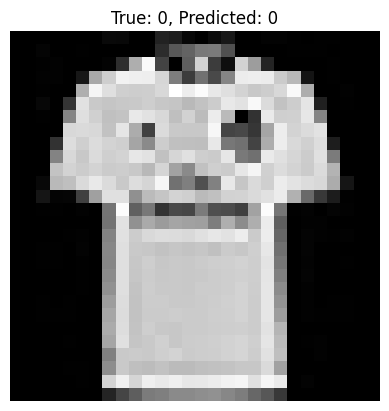

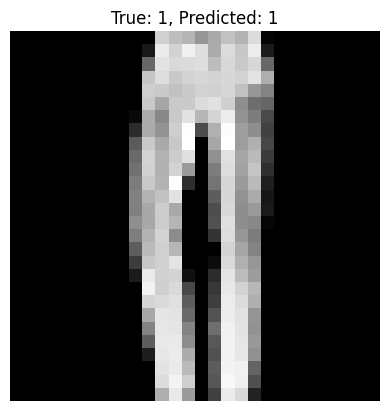

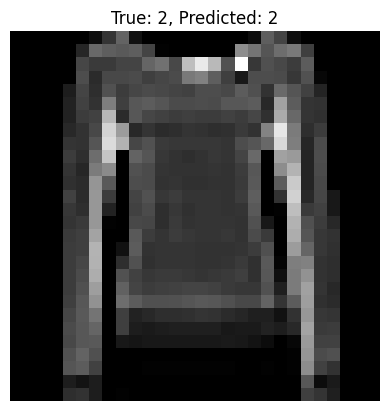

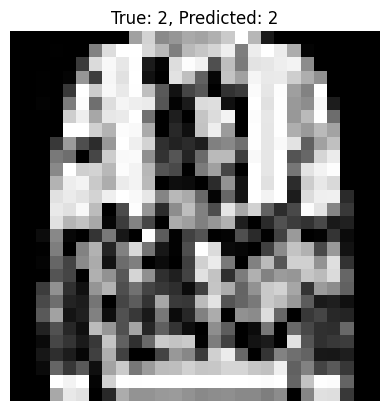

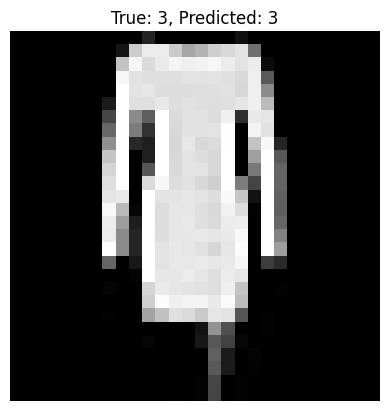

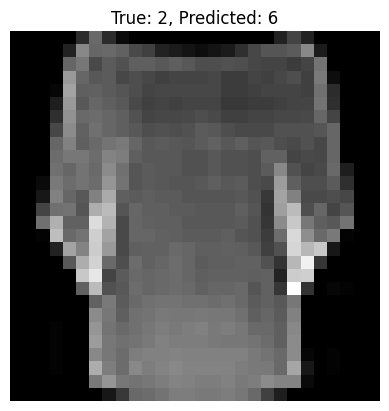

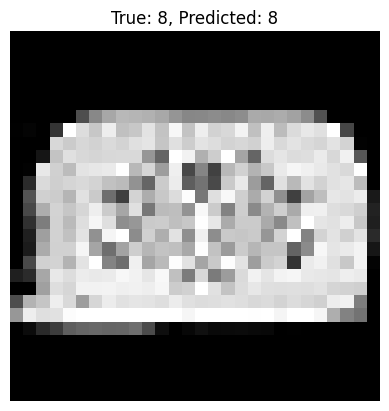

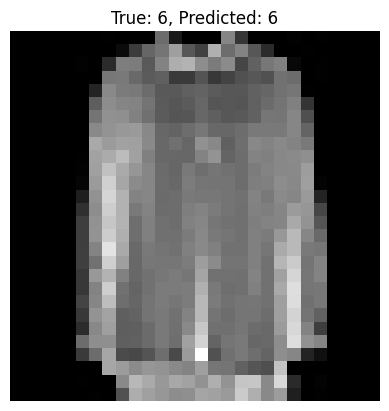

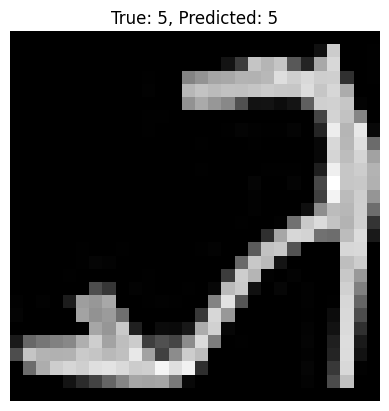

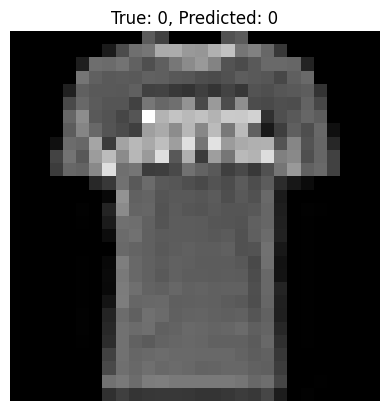

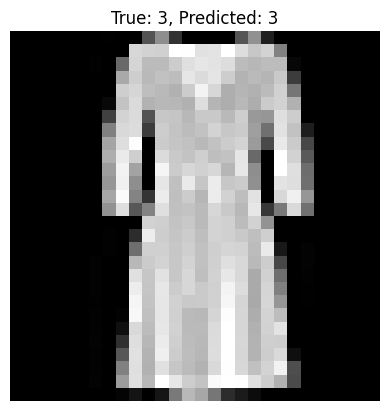

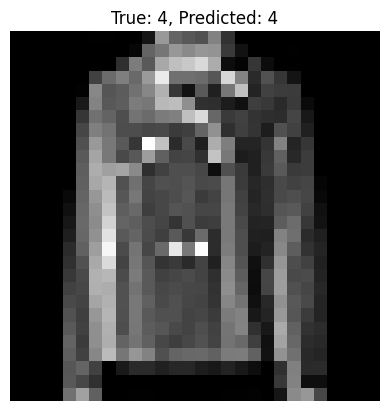

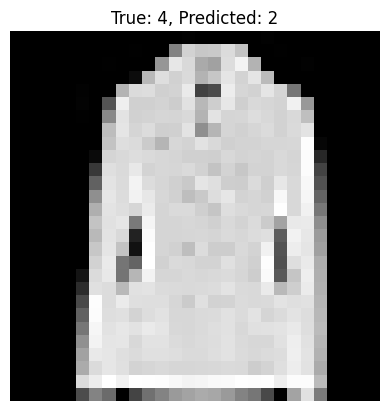

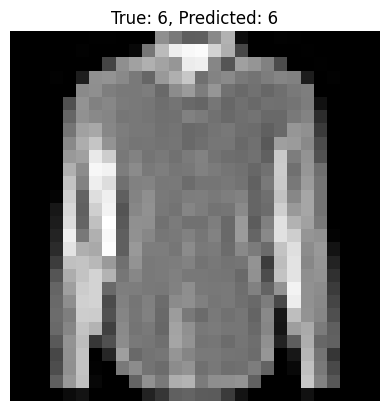

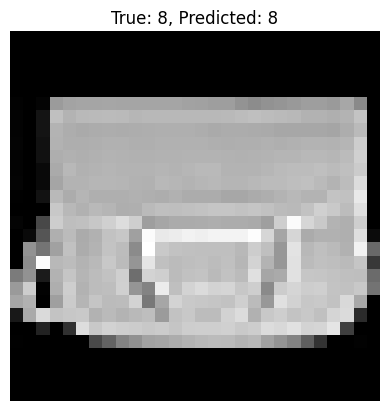

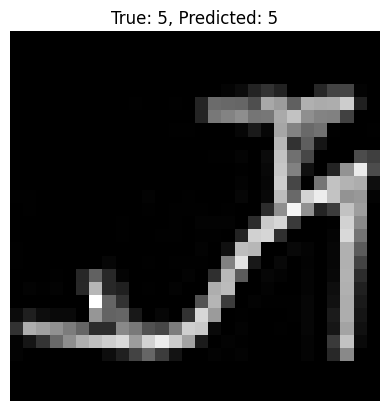

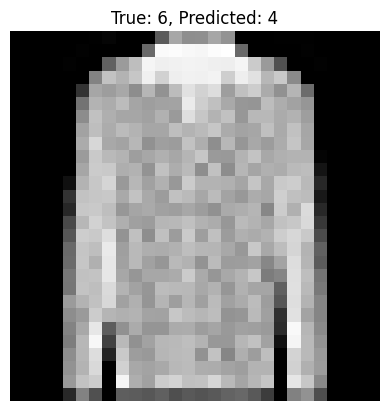

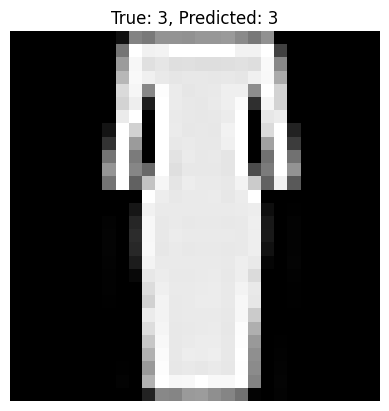

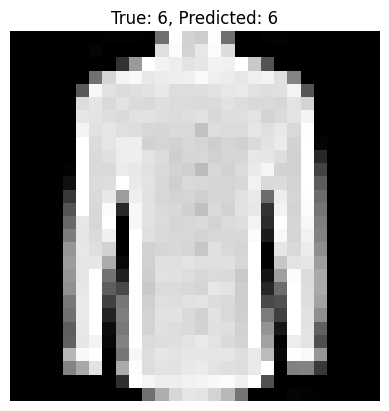

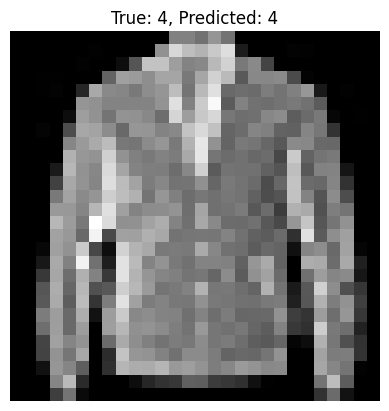

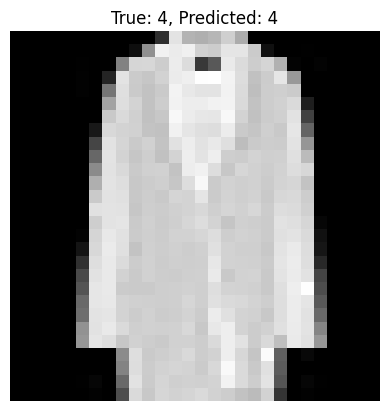

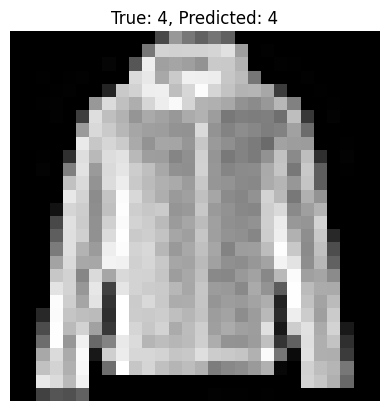

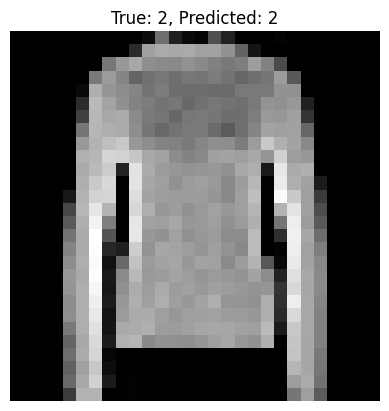

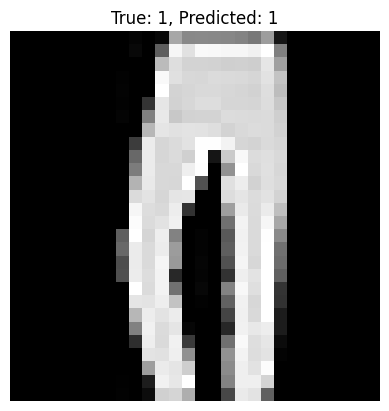

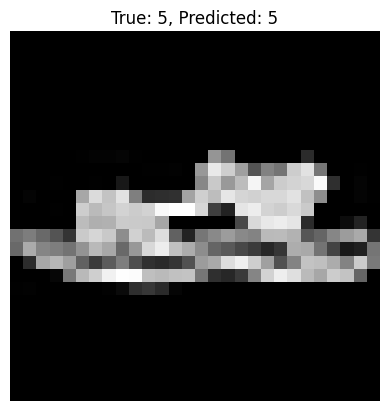

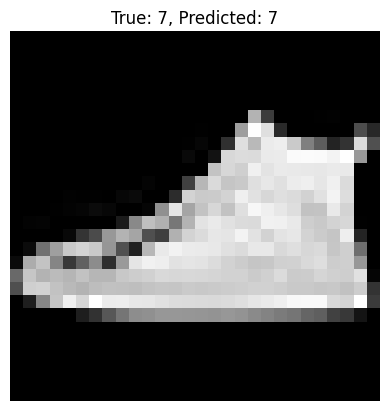

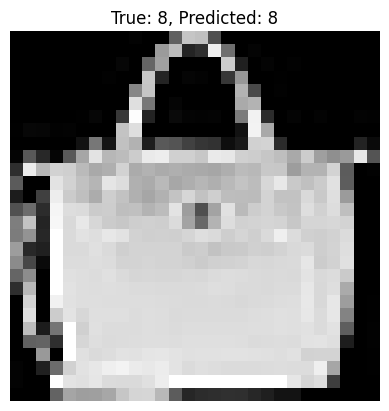

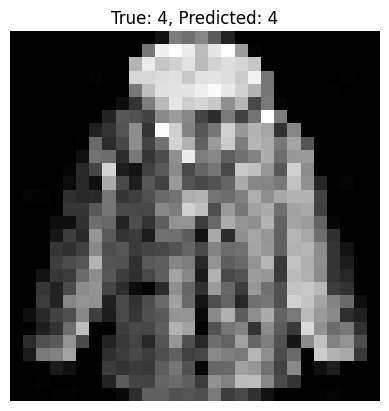

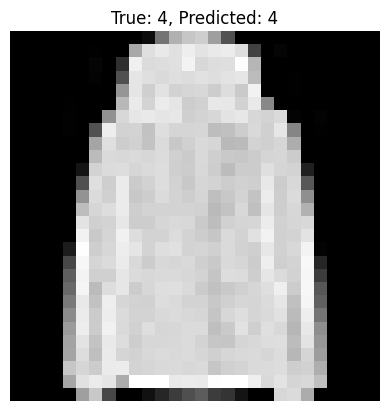

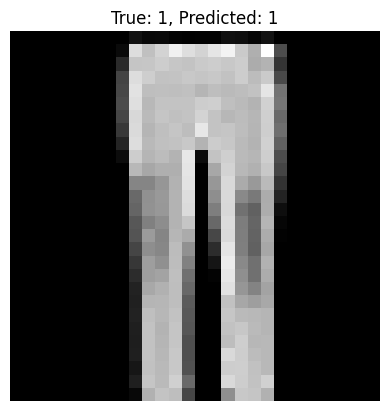

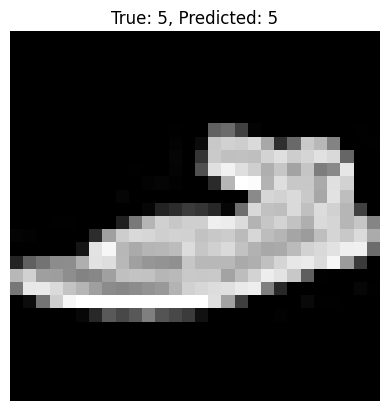

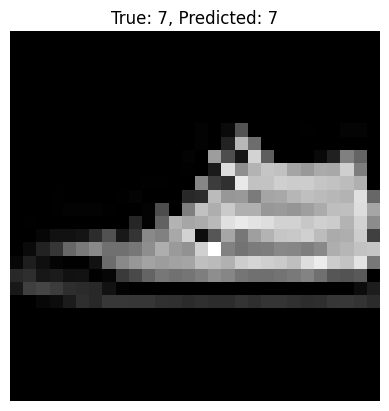

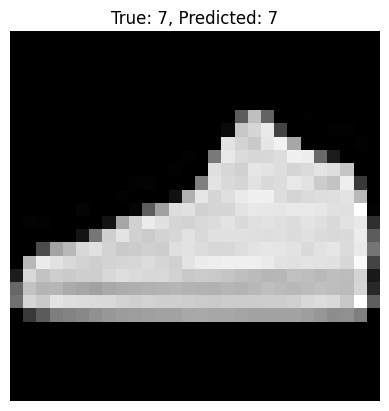

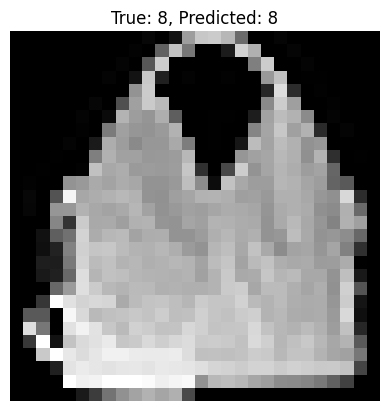

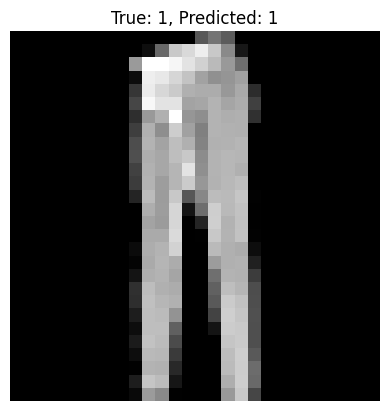

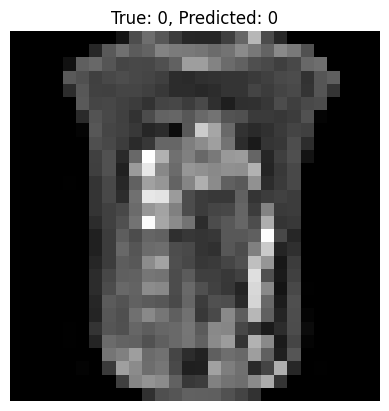

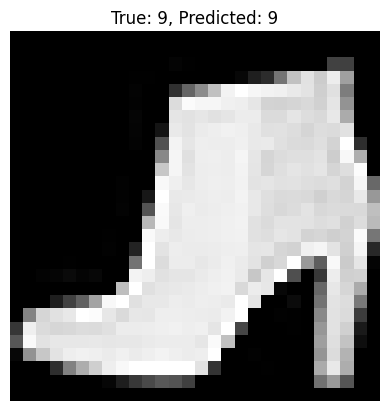

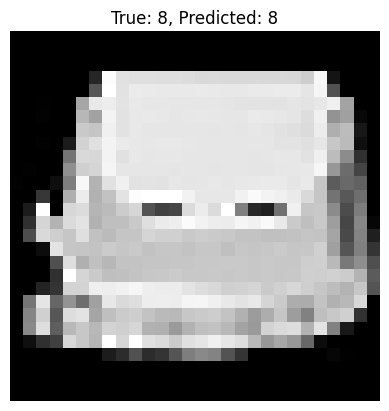

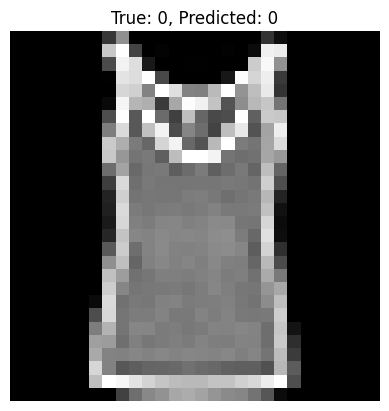

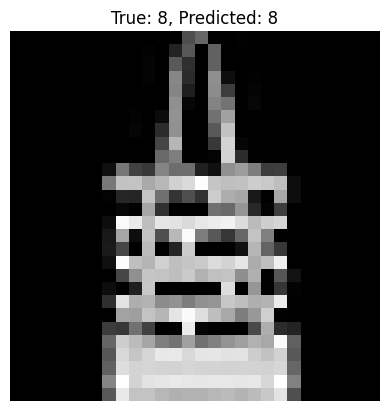

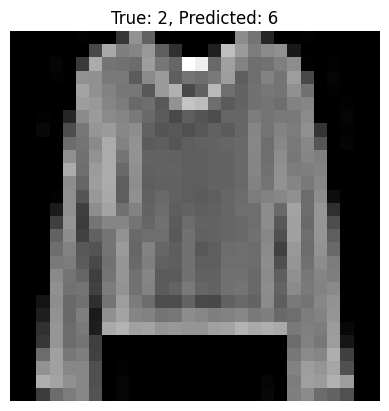

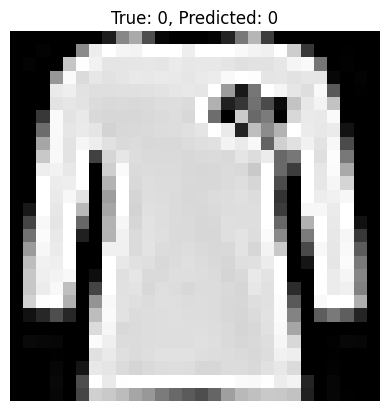

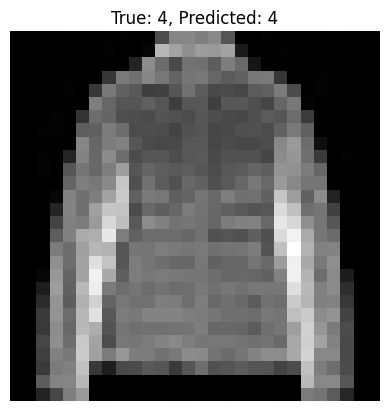

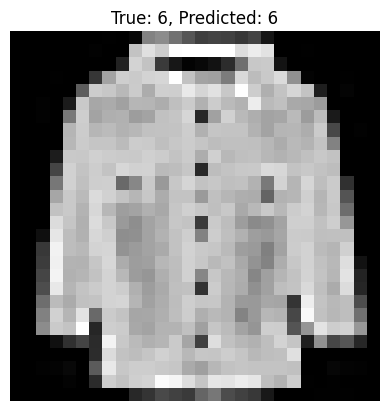

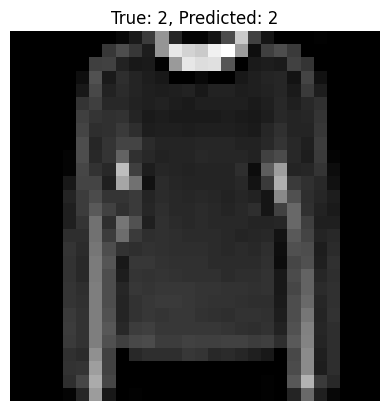

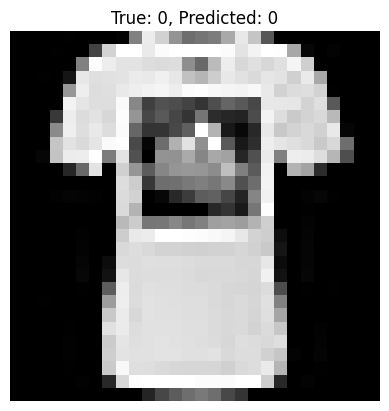

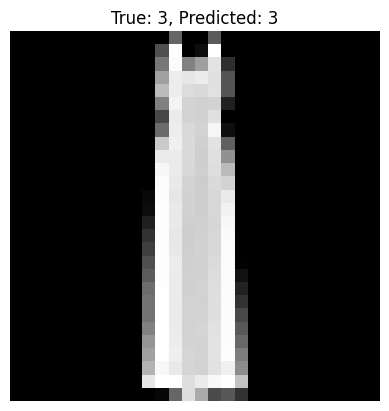

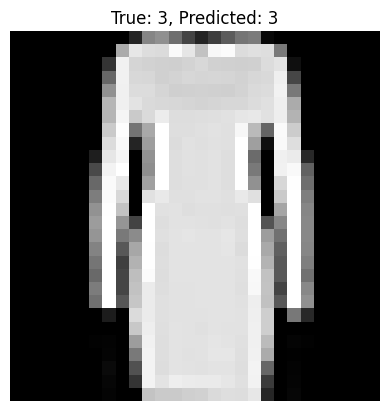

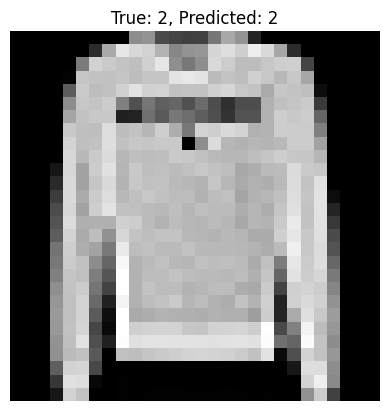

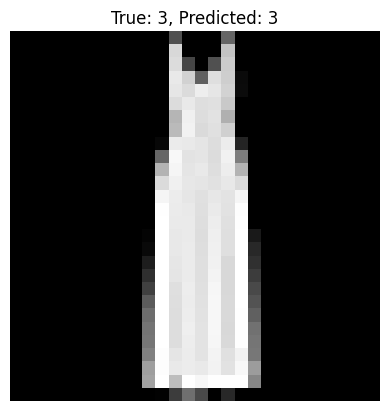

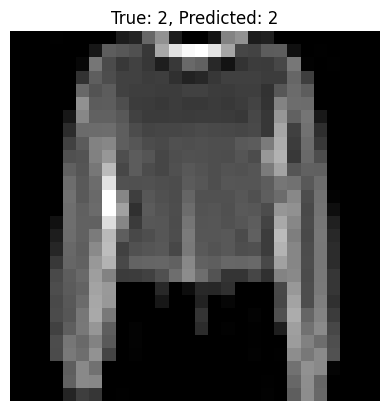

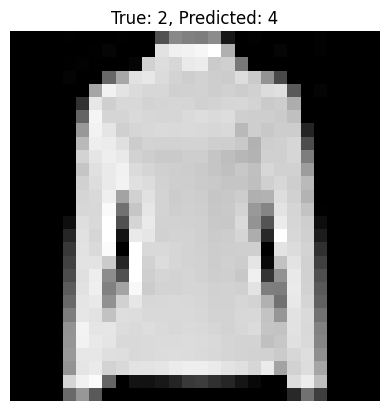

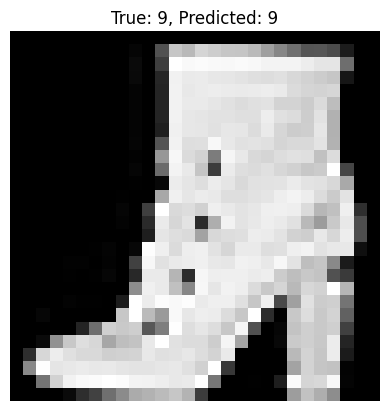

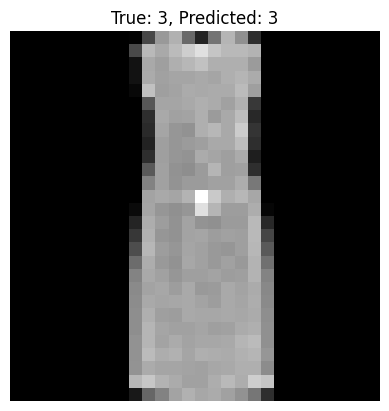

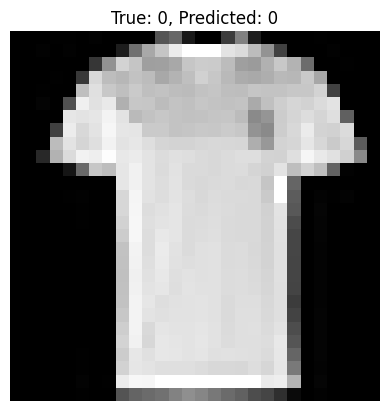

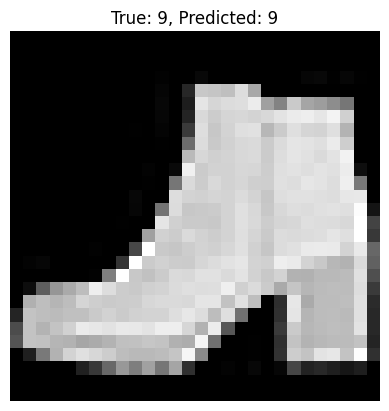

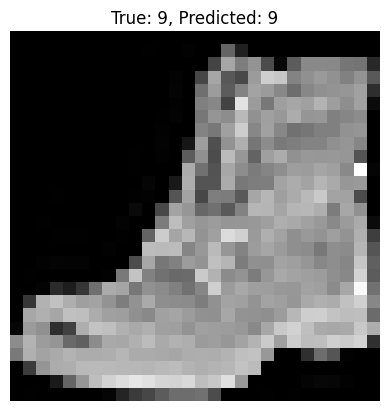

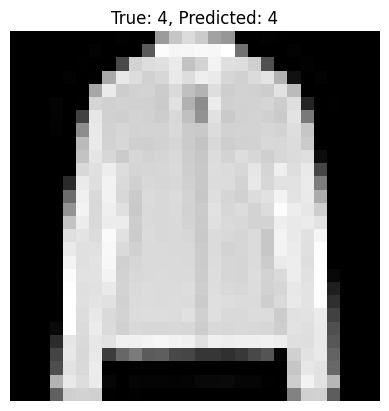

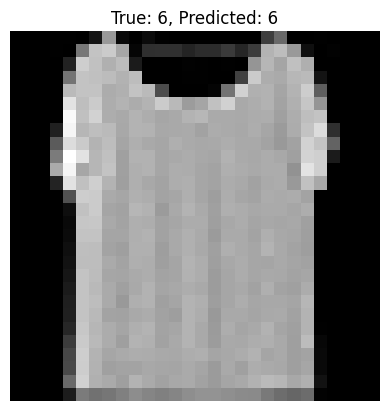

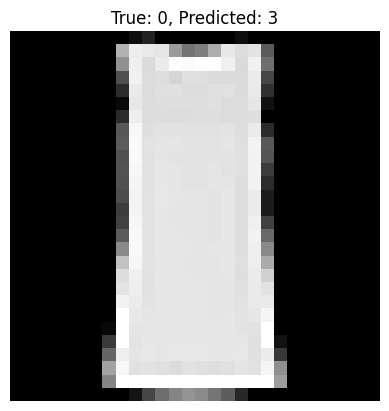

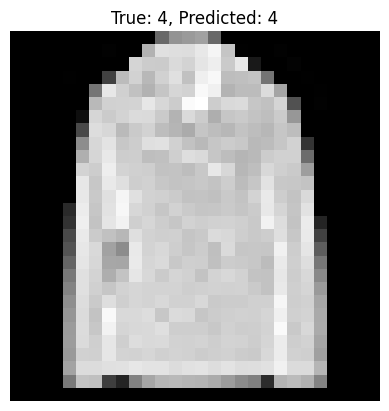

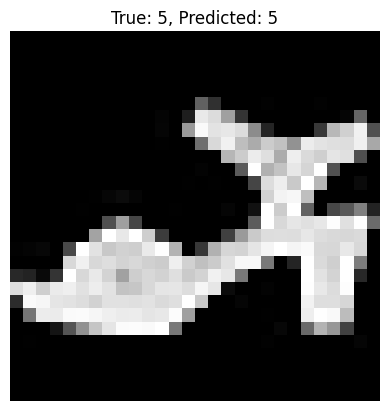

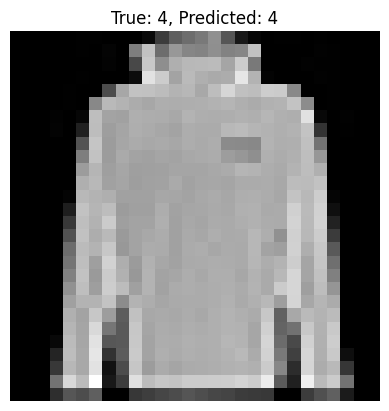

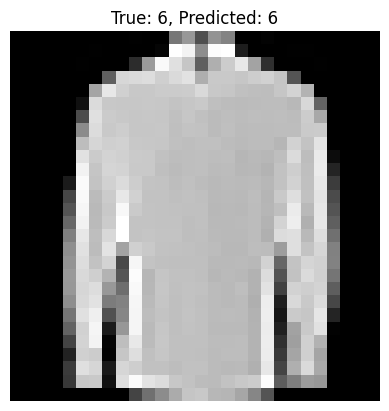

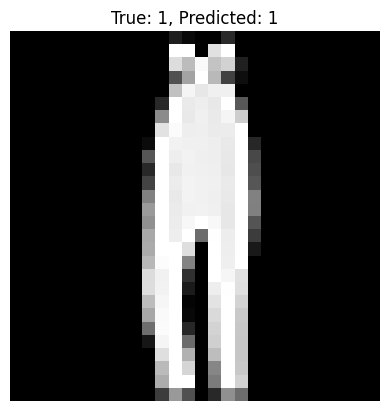

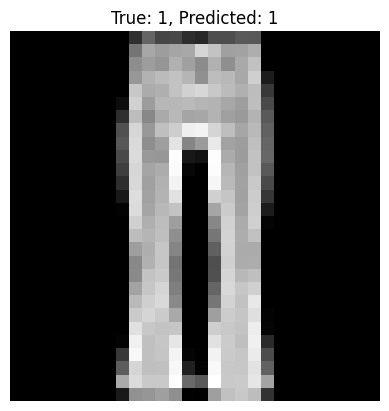

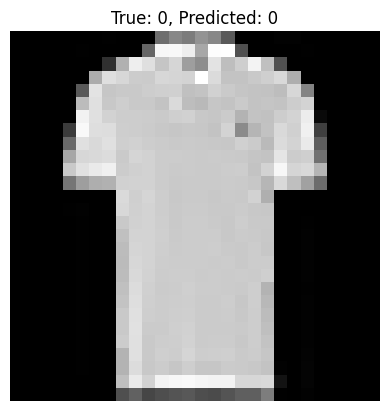

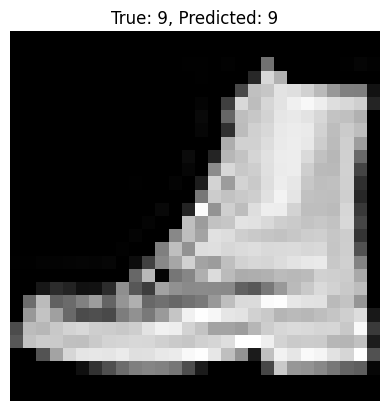

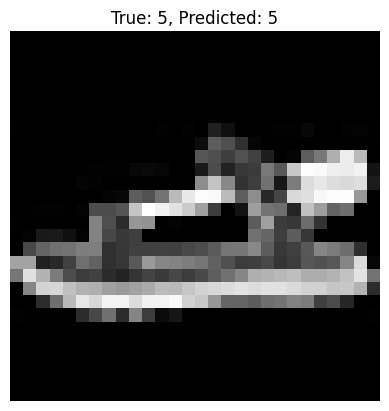

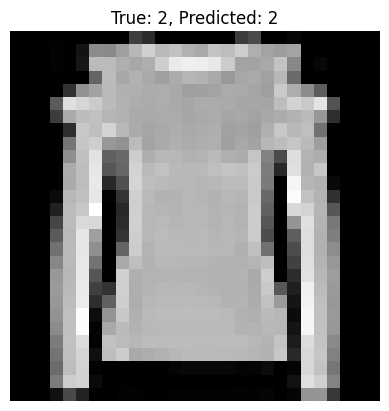

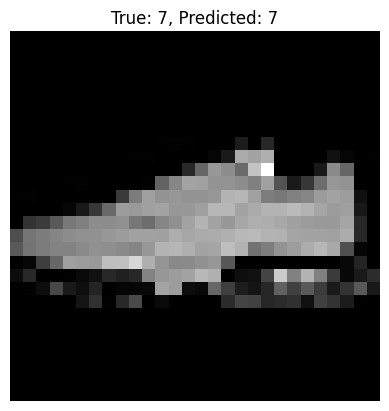

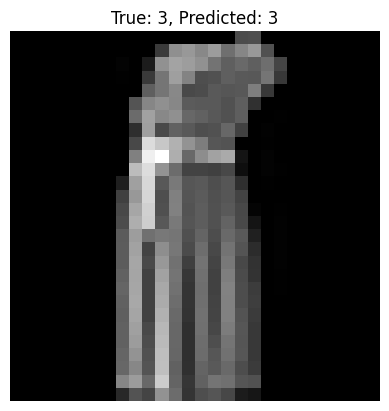

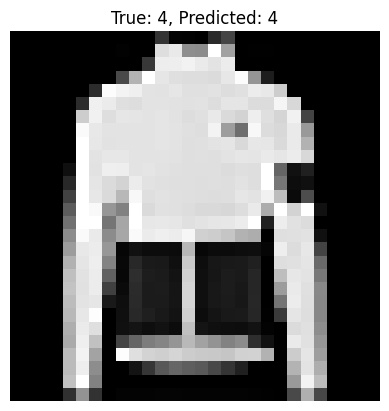

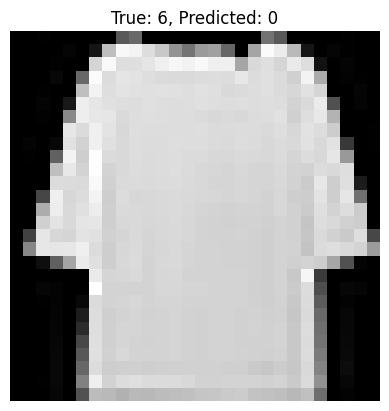

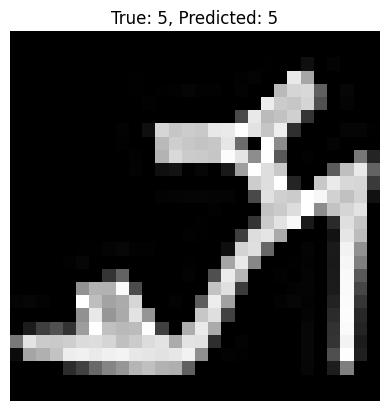

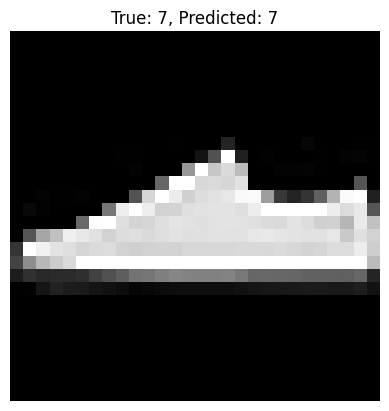

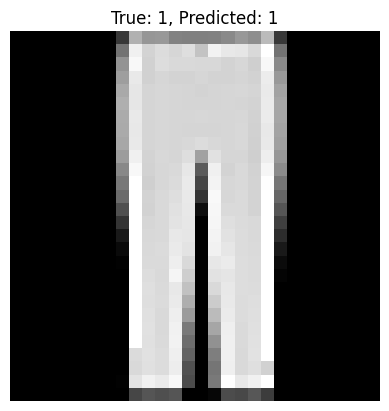

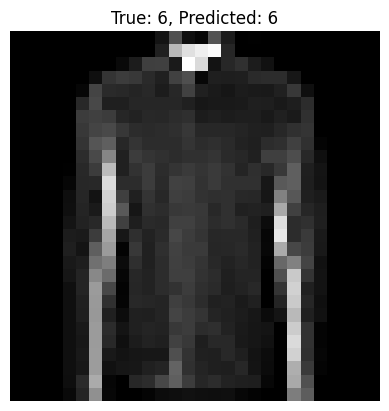

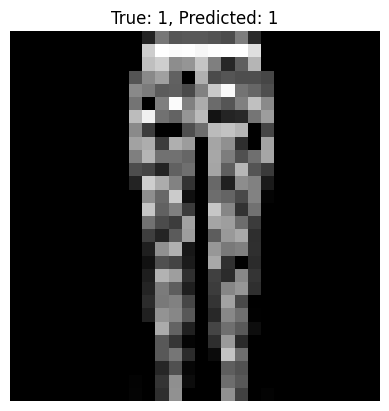

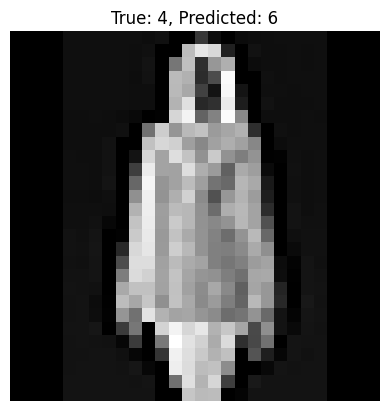

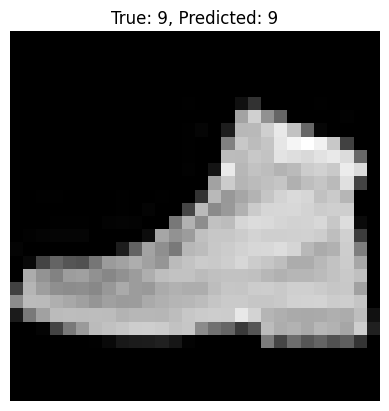

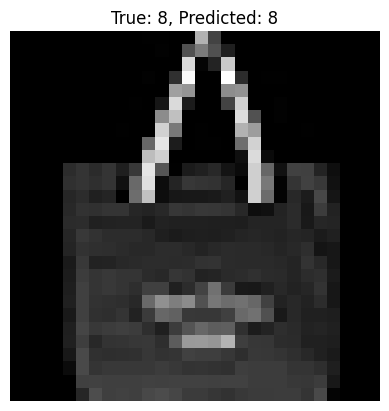

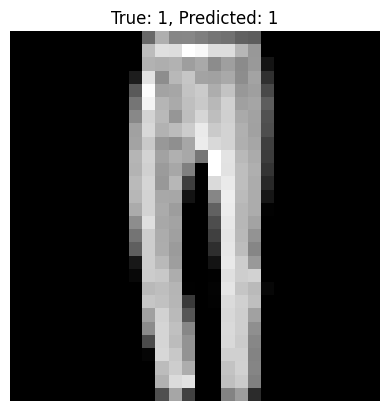

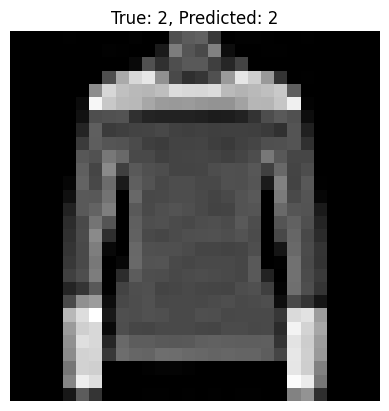

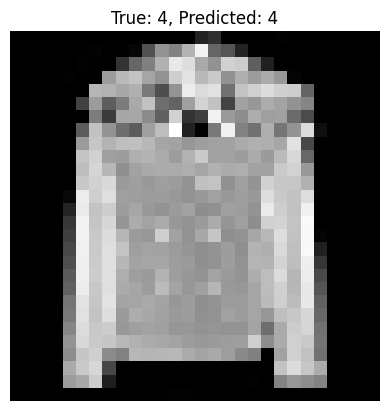

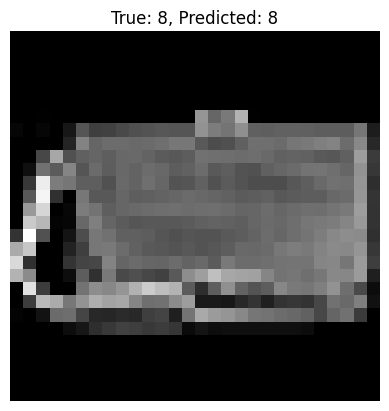

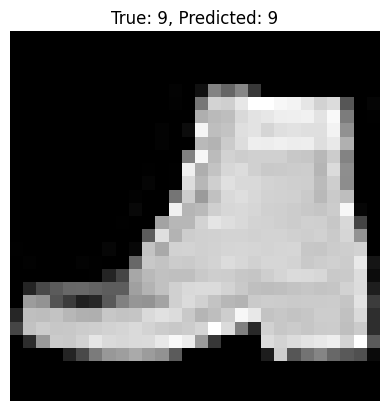

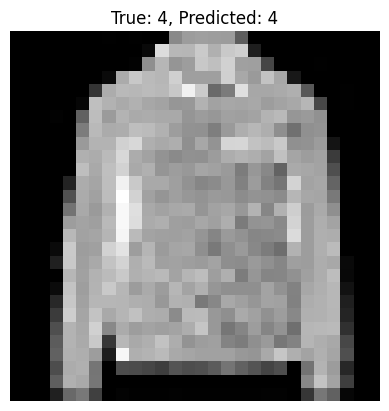

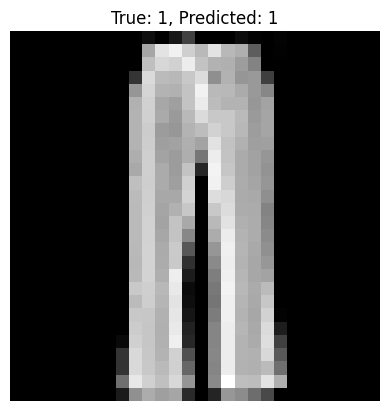

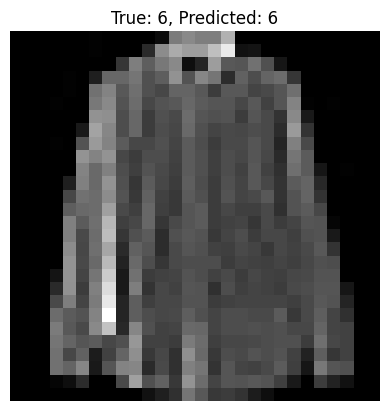

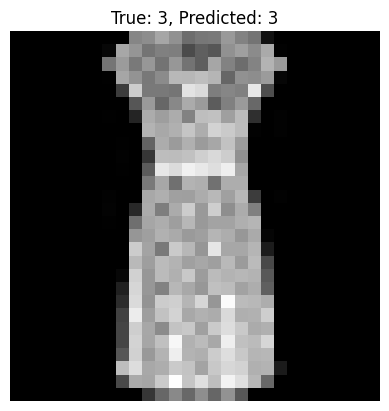

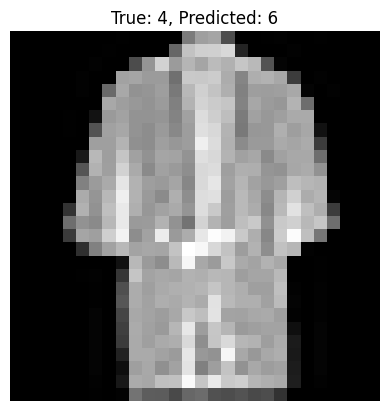

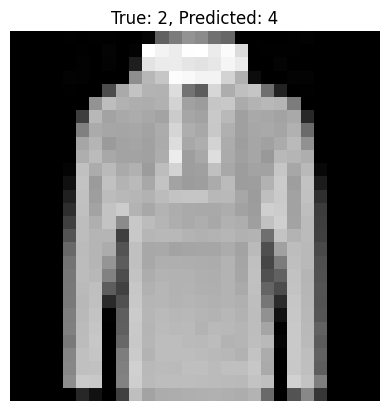

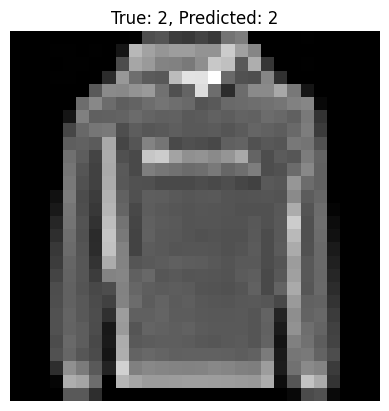

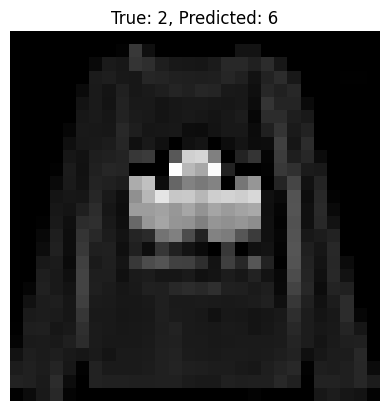

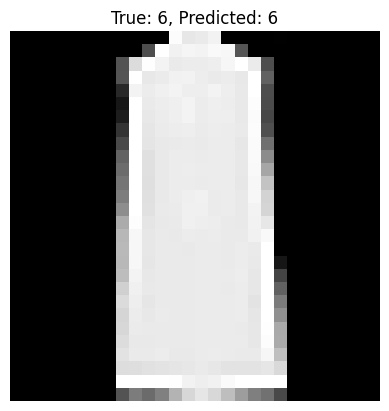

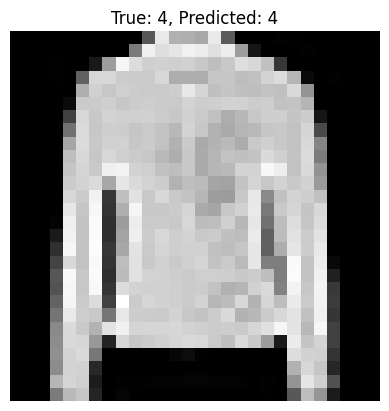

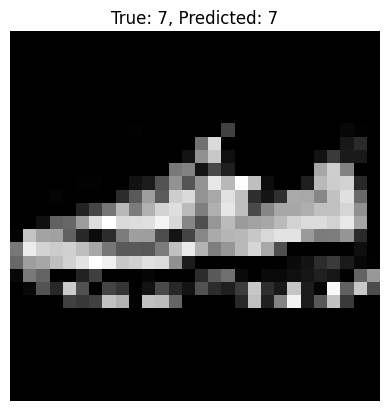

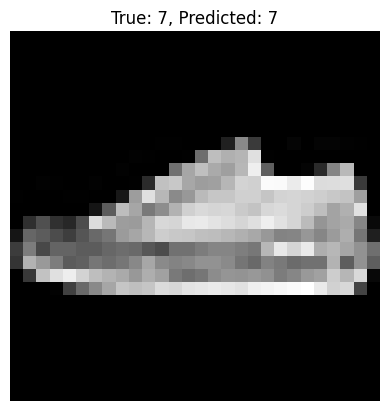

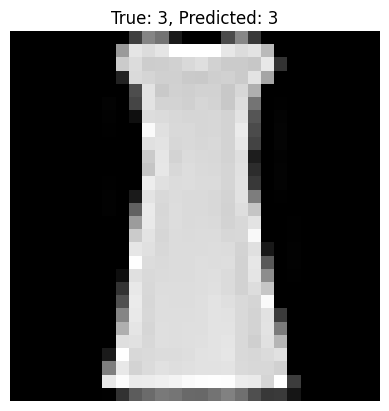

In [5]:
# test dataset
data_test = pd.read_csv(os.path.join(zalando_research_fashionmnist_path, "fashion-mnist_test.csv"))
data_test = np.array(data_test).T   # Shape: (785, 10000)

# Split into labels and features
Y_test = data_test[0]                # Labels
X_test = data_test[1:785] / 255.0    # Normalize features

# One-hot encode test labels
Y_test_oh = one_hot(Y_test)

# Forward pass on test data
_, _, _, _, _, A3_test = forward_prop(W1, b1, W2, b2, W3, b3, X_test)

# Convert softmax probabilities to predicted class
predictions_test = np.argmax(A3_test, axis=0)  # Shape: (10000,)

# Compute test accuracy
test_acc = np.mean(predictions_test == Y_test) * 100
print(f"Test Accuracy: {test_acc:.2f}%")

import matplotlib.pyplot as plt

# Show first 5 test images and predictions
for i in range(0, 100):
    image = X_test[:, i].reshape(28, 28)  # reshape from 784 vector to 28x28 image
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {Y_test[i]}, Predicted: {predictions_test[i]}")
    plt.axis('off')
    plt.show()